# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [18]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os

# Set style for plots
sns.set_theme(style='darkgrid')  
%matplotlib inline


## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [19]:
def load_data(data_dir='a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data'):
    """Load and merge physiological signal data from multiple subjects and sessions."""
    all_data = []

    for subject_id in os.listdir(data_dir):
        subject_path = os.path.join(data_dir, subject_id)
        if not os.path.isdir(subject_path) or not subject_id.startswith('S'):
            continue

        for session_name in os.listdir(subject_path):
            session_path = os.path.join(subject_path, session_name)
            if not os.path.isdir(session_path):
                continue

            session_data = {}

            for signal_file, freq, colname in [
                ('HR.csv', '1s', 'heart_rate'),
                ('EDA.csv', '250ms', 'eda'),
                ('TEMP.csv', '250ms', 'temperature')
            ]:
                file_path = os.path.join(session_path, signal_file)
                if os.path.exists(file_path):
                    df = pd.read_csv(file_path, header=None)
                    df.columns = [colname]
                    df['timestamp'] = pd.date_range(start='2023-01-01', periods=len(df), freq=freq)
                    df = df.set_index('timestamp').resample('1s').mean()
                    session_data[colname] = df

            if len(session_data) == 3:
                merged = pd.concat(session_data.values(), axis=1)
                merged = merged.reset_index()
                merged['subject_id'] = subject_id
                merged['session'] = session_name
                all_data.append(merged)

    if all_data:
        full_data = pd.concat(all_data, ignore_index=True)
        return full_data
    else:
        print("No data loaded.")
        return pd.DataFrame()

In [ ]:

df = load_data()
print(df.columns)

Index(['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id',
       'session'],
      dtype='object')


## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [20]:
def preprocess_data(data, output_dir='/workspaces/4-it-s-about-time-ayabz22/data/processed'):
    """Clean and prepare the physiological data for analysis."""

    required_cols = ['timestamp', 'heart_rate', 'eda', 'temperature']
    missing_cols = [col for col in required_cols if col not in data.columns]

    if missing_cols:
        print(f"Warning: Missing columns: {missing_cols}")
        return None

    os.makedirs(output_dir, exist_ok=True)

    # Drop rows with missing values in key columns
    data = data.dropna(subset=['heart_rate', 'eda', 'temperature'])

    print(f"Rows before filtering: {len(data)}")

    # Remove outliers using z-score with threshold = 3
    numeric_cols = ['heart_rate', 'eda', 'temperature']
    z_scores = np.abs(stats.zscore(data[numeric_cols], nan_policy='omit'))
    mask = (z_scores < 3).all(axis=1)

    if mask.sum() == 0:
        print("Warning: All data removed by filtering. Skipping filtering.")
        data_clean = data  
    else:
        data_clean = data[mask]

    print(f"Rows after filtering: {len(data_clean)}")

    output_path = os.path.join(output_dir, 'preprocessed_data.csv')
    data_clean.to_csv(output_path, index=False)

    print(f"Preprocessed data saved to {output_path}")
    return data_clean

## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

In [21]:
def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    """Create plots of physiological signals for a given subject and session."""
    os.makedirs(output_dir, exist_ok=True)

    subset = data[(data['subject_id'] == subject_id) & (data['session'] == session)]

    if subset.empty:
        print(f"No data found for subject {subject_id} in session {session}.")
        return None

    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(f'Physiological Signals for {subject_id} - {session}', fontsize=16)

    axs[0].plot(subset['timestamp'], subset['heart_rate'], color='red')
    axs[0].set_ylabel('Heart Rate (bpm)')
    axs[0].set_title('Heart Rate')

    axs[1].plot(subset['timestamp'], subset['eda'], color='blue')
    axs[1].set_ylabel('EDA (μS)')
    axs[1].set_title('Electrodermal Activity')

    axs[2].plot(subset['timestamp'], subset['temperature'], color='green')
    axs[2].set_ylabel('Temperature (°C)')
    axs[2].set_xlabel('Timestamp')
    axs[2].set_title('Skin Temperature')

    plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=45)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    filename = f'{subject_id}_{session.replace(" ", "_")}_signals.png'
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath)
    print(f"Plot saved to {filepath}")

    return fig

Columns in raw data: Index(['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id',
       'session'],
      dtype='object')
Rows before filtering: 443062
Rows after filtering: 443032
Preprocessed data saved to /workspaces/4-it-s-about-time-ayabz22/data/processed/preprocessed_data.csv
Plot saved to plots/S1_Midterm_1_signals.png


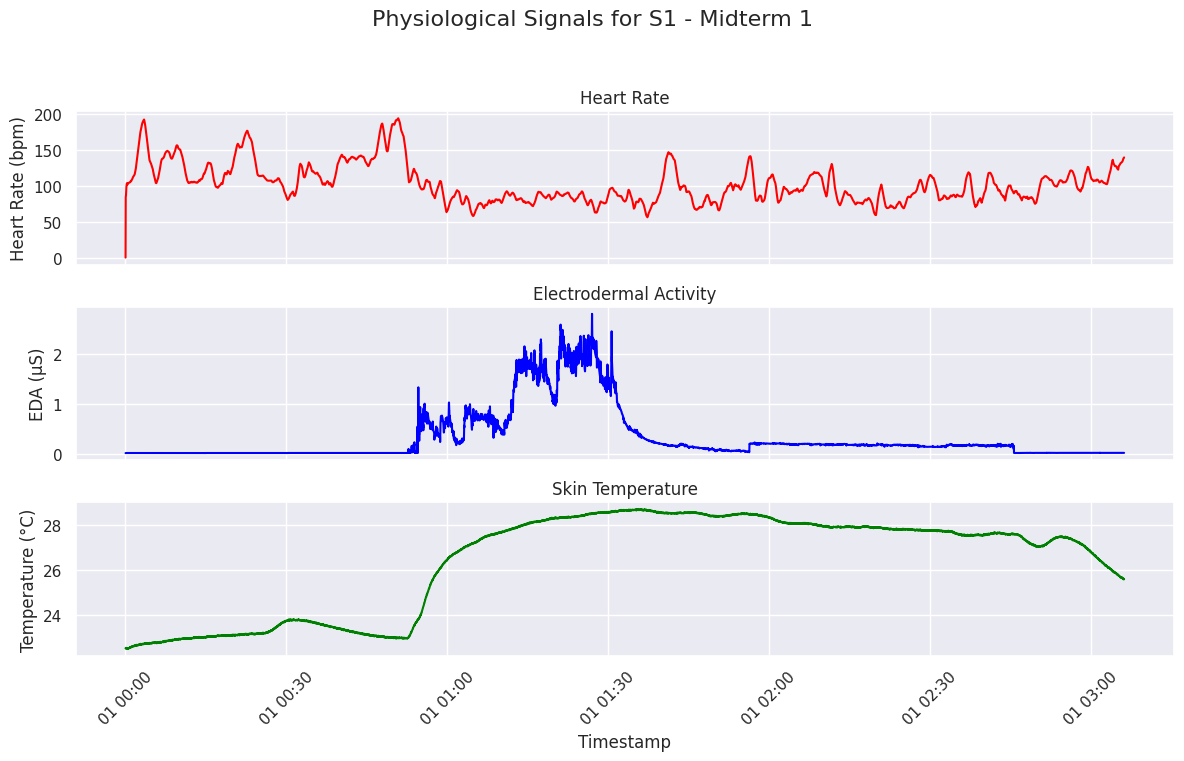

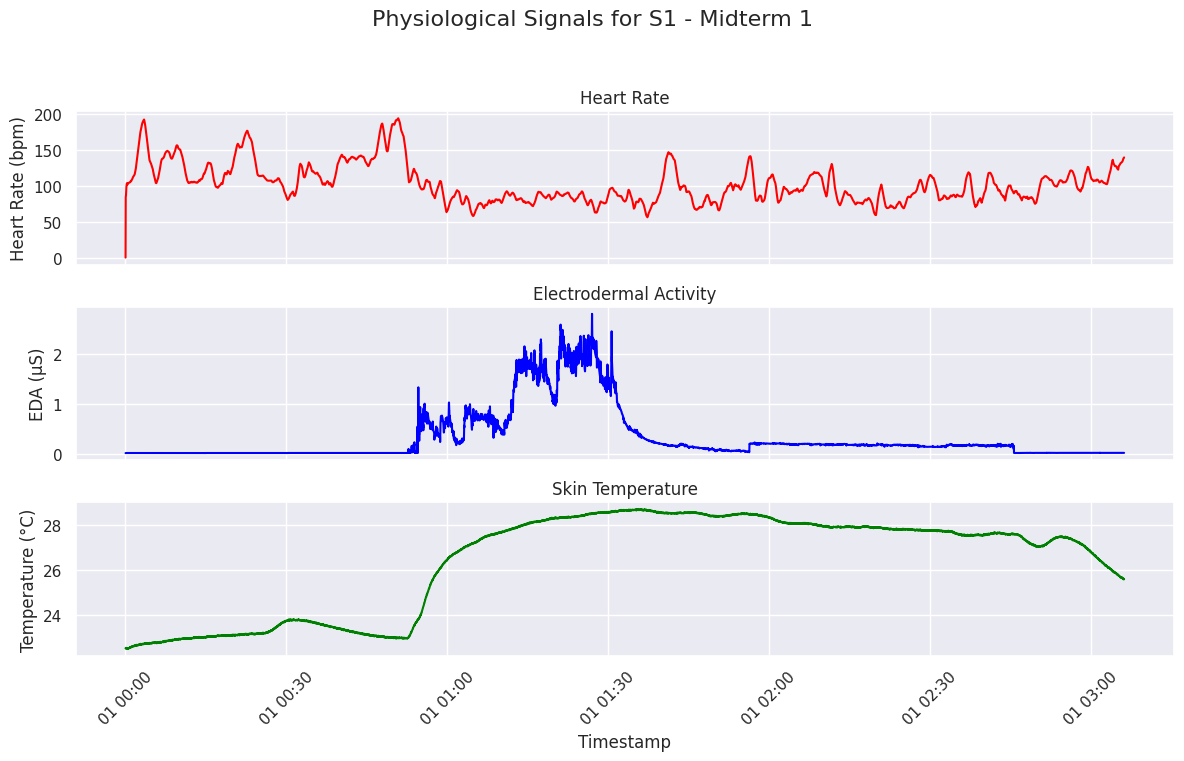

In [22]:
# Load and process data
raw_data = load_data()
print(f"Columns in raw data: {raw_data.columns}")

processed_data = preprocess_data(raw_data)

plot_physiological_signals(processed_data, subject_id='S1', session='Midterm 1')
